<a href="https://colab.research.google.com/github/thanhdtnguyen/Deep-Learning-with-Keras-Tensorflow/blob/master/convnet_dog_cat_no_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from shutil import copyfile

In [2]:
# download and extract zip file

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = "/tmp/cats-and-dogs.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp")
zip_ref.close()

--2020-08-23 01:39:06--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.26.80.188, 2600:1409:a:283::e59, 2600:1409:a:296::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.26.80.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   106MB/s    in 7.2s    

2020-08-23 01:39:13 (109 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir("/tmp/PetImages/Cat")))
print(len(os.listdir("/tmp/PetImages/Dog")))

12501
12501


In [4]:
# create directories 

try:
  base_dir = "/tmp/cats-v-dogs"
  os.mkdir(base_dir)

  training_dir = os.path.join(base_dir, "training")
  os.mkdir(training_dir)

  testing_dir = os.path.join(base_dir, "testing")
  os.mkdir(testing_dir)

  training_cats_dir = os.path.join(training_dir, "cats")
  os.mkdir(training_cats_dir)
  testing_cats_dir = os.path.join(testing_dir, "cats")
  os.mkdir(testing_cats_dir)

  training_dogs_dir = os.path.join(training_dir, "dogs")
  os.mkdir(training_dogs_dir)
  testing_dogs_dir = os.path.join(testing_dir, "dogs")
  os.mkdir(testing_dogs_dir)
except OSError:
  pass

In [5]:
# preprocess data

def split_data(source, training, testing, split_size):

  image_list = []

  file_names = os.listdir(source)
  file_number = len(file_names)

  for file_data in file_names:
      data = source + file_data
      if (os.path.getsize(data) > 0):
          image_list.append(file_data)
      else:
          print(file_data + " is invalid, so ignoring.")
    
  shuffled_set = random.sample(image_list, len(image_list))
  
  for index, file in enumerate(shuffled_set):
    if index < int(split_size * len(image_list)):
      ftrain = copyfile(os.path.join(source, file), os.path.join(training, file))
    else:
      ftest = copyfile(os.path.join(source, file), os.path.join(testing, file))


cat_source_dir = "/tmp/PetImages/Cat/"
dog_source_dir = "/tmp/PetImages/Dog/"

split_size = .9
split_data(cat_source_dir, training_cats_dir, testing_cats_dir, split_size)
split_data(dog_source_dir, training_dogs_dir, testing_dogs_dir, split_size)

666.jpg is invalid, so ignoring.
11702.jpg is invalid, so ignoring.


In [6]:
print(len(os.listdir(training_cats_dir)))
print(len(os.listdir(training_dogs_dir)))
print(len(os.listdir(testing_cats_dir)))
print(len(os.listdir(testing_dogs_dir)))

11250
11250
1250
1250


In [7]:
# callbacks

class myCallback(keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    if logs.get("accuracy")>=0.95:
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()

In [8]:
# define a model

model = keras.models.Sequential([layers.Conv2D(16, (3,3), activation="relu", input_shape=(150,150,3)),
                                 layers.MaxPooling2D(2,2),
                                 layers.Conv2D(32, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 layers.Conv2D(64, (3,3), activation="relu"),
                                 layers.MaxPooling2D(2,2),
                                 layers.Flatten(),
                                 layers.Dense(512, activation="relu"),
                                 layers.Dense(1, activation="sigmoid")])

model.compile(optimizer=RMSprop(lr=1e-3), loss="binary_crossentropy", metrics=["accuracy"])

In [9]:
# image generator

train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=(150,150),
                                                    batch_size=100,
                                                    class_mode="binary")

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(testing_dir,
                                                              target_size=(150,150),
                                                              batch_size=50,
                                                              class_mode="binary")

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
# train the model

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/15
 16/225 [=>............................] - ETA: 54s - loss: 1.2099 - accuracy: 0.5300

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 74s 328ms/step - loss: 0.6543 - accuracy: 0.6517 - val_loss: 0.5125 - val_accuracy: 0.7464
Epoch 2/15
225/225 [==============================] - 74s 327ms/step - loss: 0.5018 - accuracy: 0.7542 - val_loss: 0.5099 - val_accuracy: 0.7460
Epoch 3/15
225/225 [==============================] - 74s 327ms/step - loss: 0.4360 - accuracy: 0.7986 - val_loss: 0.4793 - val_accuracy: 0.7796
Epoch 4/15
225/225 [==============================] - 73s 326ms/step - loss: 0.3789 - accuracy: 0.8283 - val_loss: 0.3949 - val_accuracy: 0.8160
Epoch 5/15
225/225 [==============================] - 73s 326ms/step - loss: 0.3134 - accuracy: 0.8631 - val_loss: 0.3950 - val_accuracy: 0.8288
Epoch 6/15
225/225 [==============================] - 74s 329ms/step - loss: 0.2499 - accuracy: 0.8979 - val_loss: 0.5412 - val_accuracy: 0.8112
Epoch 7/15
225/225 [==============================] - 73s 326ms/step - loss: 0.1729 - accuracy: 0.9308 - val_loss: 0.5753 - val_accuracy: 0.8

In [13]:
# save the model

model.save("convnet_dog_cat_no_augmentation_model.h5")

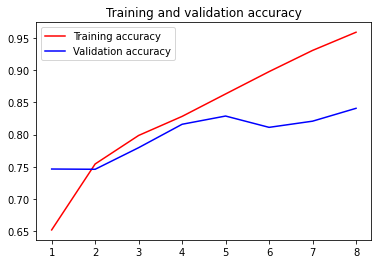

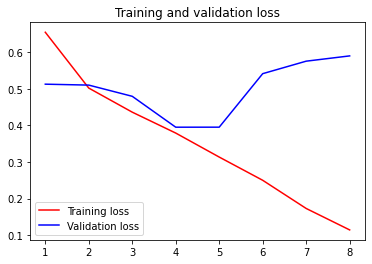

In [11]:
# plot accuracy and loss

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# accuracy

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

# loss

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()